In [107]:
# import modules

# OpenCV
import cv2

# numpy
import numpy as np

# math
import math

# matplot
from matplotlib import pyplot as plt
%matplotlib inline

# Align face
apply_align_face = 1

# LBP
apply_lpb = 0

In [108]:
# Align faces by eyes
eye_detector = cv2.CascadeClassifier("/usr/local/share/OpenCV/haarcascades/haarcascade_eye.xml")
right_eye_detector = cv2.CascadeClassifier("/usr/local/share/OpenCV/haarcascades/haarcascade_mcs_righteye.xml")
left_eye_detector = cv2.CascadeClassifier("/usr/local/share/OpenCV/haarcascades/haarcascade_mcs_lefteye.xml")

# scale image
align_scale = 1.5

def align_face(I, (x,y,w,h), i, total):
    # Extract face
    face = I[y:y+h, x:x+w]
    print "I ", I.shape
    # plot
    fig = plt.figure(figsize=(15,150))
    pos = i*5+1
    plt.subplot(total, 5, pos)
    plt.imshow(cv2.cvtColor(face, cv2.COLOR_GRAY2RGB))    
    plt.axis("off")

    # 
    scaled_height = int(h*align_scale)
    print "Scaled height: ", scaled_height
    
    # 1. Create a canvas for the image
    canvas = np.zeros(shape=(scaled_height, scaled_height), dtype=np.uint8)

    print "canvas.shape ", canvas.shape
    
    yt = int(y-math.floor((scaled_height-h)/2.))
    yb = int(y+math.ceil((scaled_height-h)/2.)+h)
    xl = int(x-math.floor((scaled_height-h)/2.))
    xr = int(x+math.ceil((scaled_height-h)/2.)+h)

    rt = 0
    rb = math.ceil(h*align_scale)
    cl = 0
    cr = math.floor(w*align_scale)

    if yt<0:
        rt = -yt
        yt = 0
    if xl<0:
        cl = -xl
        xl = 0
    if yb>I.shape[0]:
        rb-= yb-I.shape[0]
        yb = I.shape[0]
    if xr>I.shape[1]:
        cr-= xr-I.shape[1]
        xr = I.shape[1]
        
    # 2. Copy image' fragment to canvas
    print "x, y, w, h", x, y, w, h
    print "yt:yb, xl:xr", yt, yb, xl, xr
    print "rt:rb, cl:cr", rt, rb, cl, cr
    canvas[rt:rb, cl:cr] = I[yt:yb, xl:xr]
    cols, rows = canvas.shape

    print "canvas.shape, cols, rows, I.shape, type(I), type(canvas)", canvas.shape, cols, rows, I.shape, type(I[0][0]), type(canvas[0][0])
    
    # plot
    pos = i*5+2
    plt.subplot(total, 5, pos)
    plt.imshow(cv2.cvtColor(canvas, cv2.COLOR_GRAY2RGB))    
    #plt.imshow(canvas)    
    plt.axis("off")
    
    # Detect eyes
    left_eye = left_eye_detector.detectMultiScale(face)
    right_eye = right_eye_detector.detectMultiScale(face)
    eye = eye_detector.detectMultiScale(face)
    print "left_eye, right_eye, eye", len(left_eye), len(right_eye), len(eye)
    '''
    for (ex,ey,ew,eh) in left_eye: 
        cv2.rectangle(face,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)    
        pos = i*5+3
        plt.subplot(total, 5, pos)
        plt.imshow(cv2.cvtColor(face, cv2.COLOR_GRAY2RGB))    
        plt.axis("off")
'''

    print "left_eye: ", left_eye
    print "right_eye: ", right_eye    
        
    # Calc angle rotate
    left_eye_center, right_eye_center = 0, 0
    eyes = []
    if len(eye)==2: eyes = eye
    elif len(left_eye)==2: eyes = left_eye
    elif len(right_eye)==2: eyes = right_eye
    elif len(left_eye)>1: eyes = left_eye[:2]
    elif len(right_eye)>1: eyes = right_eye[:2]
    elif len(left_eye) and len(right_eye):
        eyes.append(left_eye[0])
        eyes.append(right_eye[0])

    if len(eyes):
        left_eye_center = ((eyes[0][0] + eyes[0][2])/2, (eyes[0][1] + eyes[0][3])/2, )
        right_eye_center = ((eyes[1][0] + eyes[1][2])/2, (eyes[1][1] + eyes[1][3])/2, )

    for (ex,ey,ew,eh) in eyes: 
        #cv2.rectangle(face,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)    
        pos = i*5+3
        plt.subplot(total, 5, pos)
        plt.imshow(cv2.cvtColor(face, cv2.COLOR_GRAY2RGB))    
        plt.axis("off")

    if left_eye_center and right_eye_center:
        print "left_eye_center ", left_eye_center
        print "right_eye_center ", right_eye_center
        dx = left_eye_center[0] - right_eye_center[0]
        dy = left_eye_center[1] - right_eye_center[1]
        cos_Theta = dx/((dx**2+dy**2)**.5)
        rotation = -1
        if cos_Theta>0: 
            rotation = 1
        sin_Theta = dy/((dx**2+dy**2)**.5)
        M = np.matrix([[rotation*cos_Theta, rotation*sin_Theta, (1-rotation*cos_Theta)*cols/2-rotation*sin_Theta*rows/2],[-rotation*sin_Theta, rotation*cos_Theta, rotation*sin_Theta*cols/2+(1-rotation*cos_Theta)/rows/2]])
        print "dx, dy", dx, dy
        print "cos_Theta, sin_Theta", cos_Theta, sin_Theta
        print "M ", M
        degrees = math.degrees(math.acos(math.fabs(cos_Theta)))
        print "degrees ", degrees
        #M = cv2.getRotationMatrix2D((cols/2,rows/2),degrees*rotation,1)
        #print "M ", M
        dst = cv2.warpAffine(canvas,M,(cols,rows))

        # plot
        pos = i*5+4
        plt.subplot(total, 5, pos)
        plt.imshow(cv2.cvtColor(dst, cv2.COLOR_GRAY2RGB))    
        plt.axis("off")

        # Extract aligned face
        A = face_detector.detectMultiScale(dst, 1.3, 5)
        if len(A):
            face = dst[A[0][1]:A[0][1]+A[0][3], A[0][0]:A[0][0]+A[0][2]]

        # plot
        pos = i*5+5
        plt.subplot(total, 5, pos)
        plt.imshow(cv2.cvtColor(face, cv2.COLOR_GRAY2RGB))    
        plt.axis("off")
    #else: face = None
        
    return face

In [109]:
# Enter test images file names
group_img = raw_input("Please, enter group image file name: ")
single_img = raw_input("Please, enter single image file name: ")

# or by default
if group_img == "": group_img = "../test/g3.jpg"
if single_img == "": single_img = "../test/s3.jpg"    

Please, enter group image file name: 
Please, enter single image file name: 


In [110]:
# Read images files
# G - image of group of people
# S - image of a single person
G = cv2.imread(group_img)
S = cv2.imread(single_img)

(-0.5, 384.5, 565.5, -0.5)

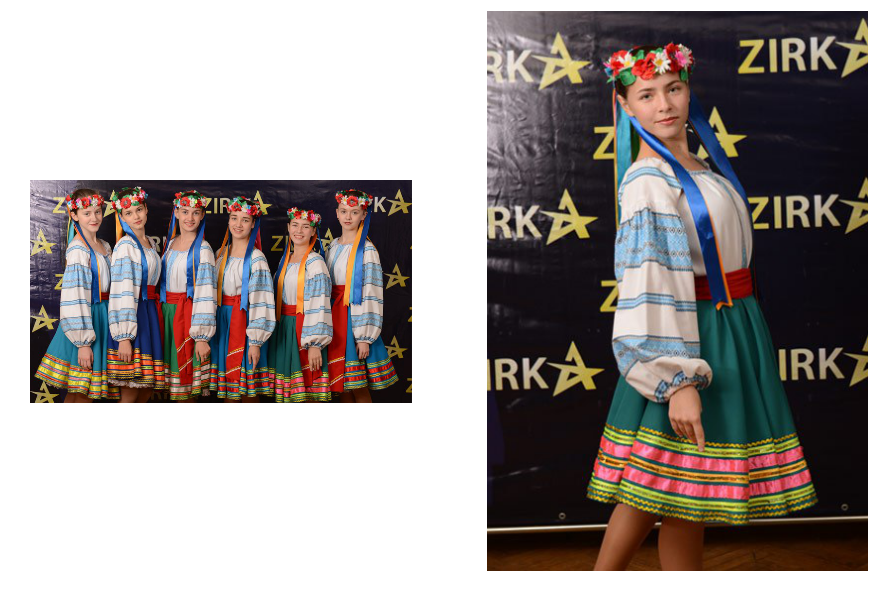

In [111]:
# plot group image
fig = plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(cv2.cvtColor(G, cv2.COLOR_BGR2RGB))    
plt.axis("off")

# plot single image
plt.subplot(122)
plt.imshow(cv2.cvtColor(S, cv2.COLOR_BGR2RGB))    
plt.axis("off")

In [112]:
# Convert original RGB images to grayscale
G_gray = cv2.cvtColor(G, cv2.COLOR_BGR2GRAY)
S_gray = cv2.cvtColor(S, cv2.COLOR_BGR2GRAY)

(-0.5, 384.5, 565.5, -0.5)

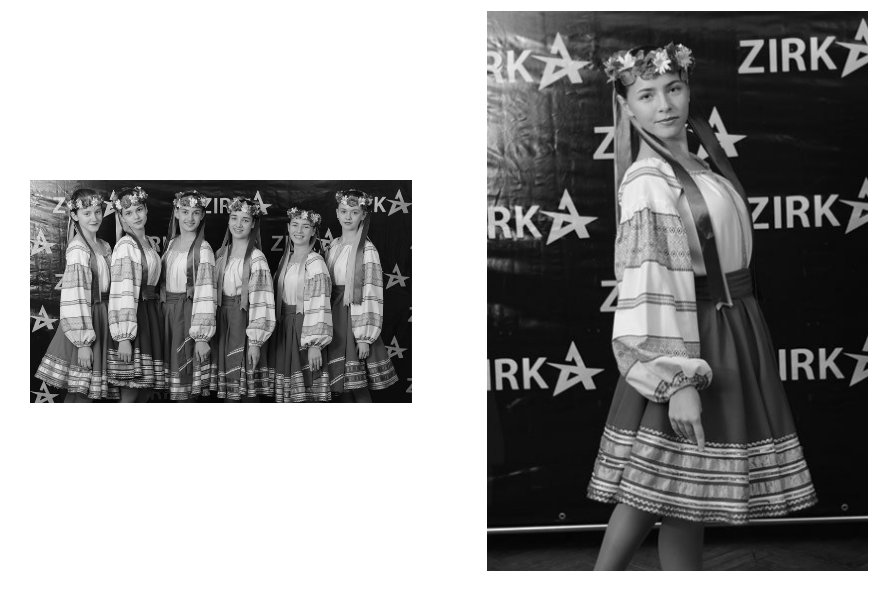

In [113]:
# plot group image
fig = plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(cv2.cvtColor(G_gray, cv2.COLOR_GRAY2RGB))    
plt.axis("off")

# plot single image
plt.subplot(122)
plt.imshow(cv2.cvtColor(S_gray, cv2.COLOR_GRAY2RGB))    
plt.axis("off")

In [114]:
# Create face detector
face_detector = cv2.CascadeClassifier("/usr/local/share/OpenCV/haarcascades/haarcascade_frontalface_alt.xml")

# Detect group faces
G_faces = face_detector.detectMultiScale(G_gray, 1.3, 5)

# Detect sigle faces
S_faces = face_detector.detectMultiScale(S_gray, 1.3, 5)

In [115]:
# check faces in group image
for x,y,w,h in G_faces:
    cv2.rectangle(G,(x,y),(x+w,y+h),(255,0,0),2)

# check faces in single image
for x,y,w,h in S_faces:
    cv2.rectangle(S,(x,y),(x+w,y+h),(255,0,0),2)

(-0.5, 384.5, 565.5, -0.5)

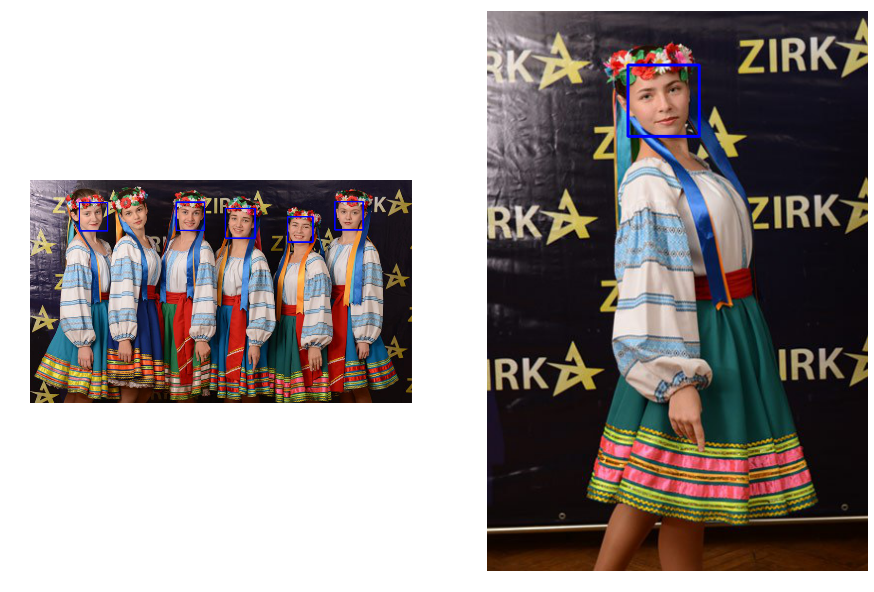

In [116]:
# plot group image
fig = plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(cv2.cvtColor(G, cv2.COLOR_BGR2RGB))    
plt.axis("off")

# plot single image
plt.subplot(122)
plt.imshow(cv2.cvtColor(S, cv2.COLOR_BGR2RGB))    
plt.axis("off")

In [117]:
# Mean face size
x_mean = int(math.floor(G_faces[:,3].mean()))

In [118]:
# Create matrix 
X = np.zeros(shape=(G_faces.shape[0], x_mean**2))
X_test = np.zeros(shape=(S_faces.shape[0], x_mean**2))

<img src="rotation_matrix.png"/>
or
<img src="affine_transformation_matrix.png"/>

I  (460, 785)
Scaled height:  87
canvas.shape  (87, 87)
x, y, w, h 101 48 58 58
yt:yb, xl:xr 34 121 87 174
rt:rb, cl:cr 0 87.0 0 87.0
canvas.shape, cols, rows, I.shape, type(I), type(canvas) (87, 87) 87 87 (460, 785) <type 'numpy.uint8'> <type 'numpy.uint8'>
left_eye, right_eye, eye 1 1 1
left_eye:  [[ 4 15 24 16]]
right_eye:  [[29 15 19 13]]
left_eye_center  (14, 15)
right_eye_center  (24, 14)
dx, dy -10 1
cos_Theta, sin_Theta -0.99503719021 0.099503719021
M  [[ 0.99503719 -0.09950372  4.544294  ]
 [ 0.09950372  0.99503719 -4.32838326]]
degrees  5.7105931375
I  (460, 785)
Scaled height:  87
canvas.shape  (87, 87)
x, y, w, h 300 47 58 58
yt:yb, xl:xr 33 120 286 373
rt:rb, cl:cr 0 87.0 0 87.0
canvas.shape, cols, rows, I.shape, type(I), type(canvas) (87, 87) 87 87 (460, 785) <type 'numpy.uint8'> <type 'numpy.uint8'>
left_eye, right_eye, eye 2 2 1
left_eye:  [[ 8 15 22 14]
 [32 17 20 13]]
right_eye:  [[ 9 15 20 13]
 [31 16 22 15]]
left_eye_center  (15, 14)
right_eye_center  (26, 15)
dx, d

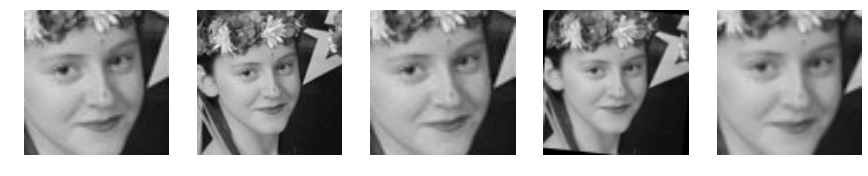

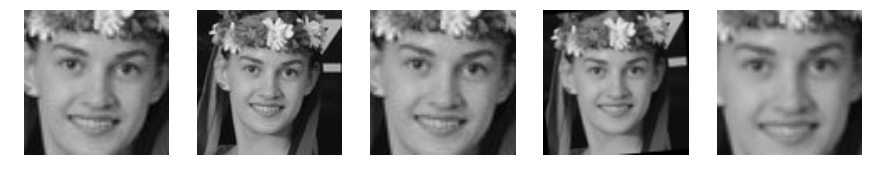

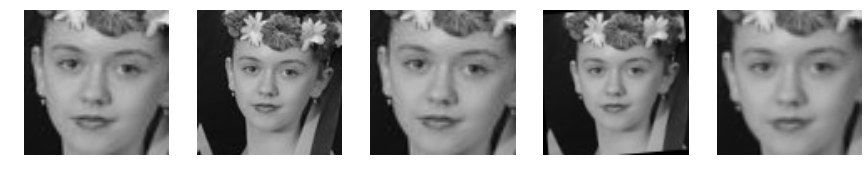

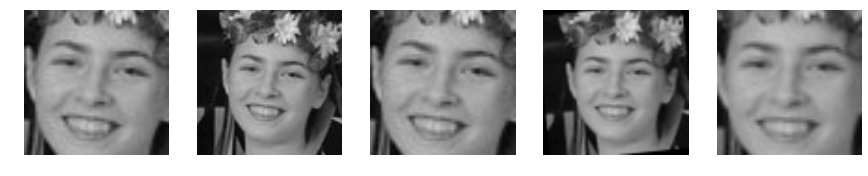

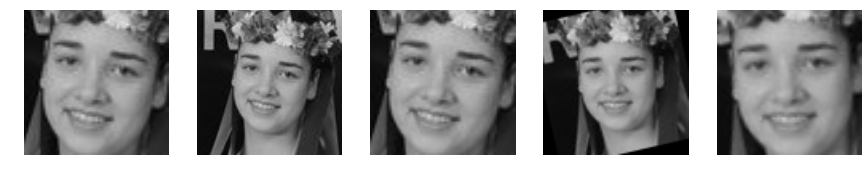

In [119]:
# Align group faces
for i,(x,y,w,h) in enumerate(G_faces):
    # Extract face
    img = G_gray[y:y+h, x:x+w]

    # Align faces
    if apply_align_face:
        img = align_face(G_gray, (x,y,w,h), i, G_faces.shape[0])

    # resize image
    res = cv2.resize(img, (x_mean, x_mean), interpolation=cv2.INTER_CUBIC)

    # LBP
    radius = 3
    n_points = 24
    if apply_lpb: 
        from skimage.feature import local_binary_pattern
        res = local_binary_pattern(res, n_points, radius, method="uniform")

    # Unfold matrix to vector
    res1 = res.reshape(1, res.shape[0]*res.shape[1])

    # Add image vector to the matrix
    X[i,:] = res1

I  (566, 385)
Scaled height:  108
canvas.shape  (108, 108)
x, y, w, h 142 55 72 72
yt:yb, xl:xr 37 145 124 232
rt:rb, cl:cr 0 108.0 0 108.0
canvas.shape, cols, rows, I.shape, type(I), type(canvas) (108, 108) 108 108 (566, 385) <type 'numpy.uint8'> <type 'numpy.uint8'>
left_eye, right_eye, eye 2 2 2
left_eye:  [[37 17 23 15]
 [ 6 23 26 18]]
right_eye:  [[35 17 26 17]
 [10 25 20 14]]
left_eye_center  (28, 17)
right_eye_center  (15, 21)
dx, dy 13 -4
cos_Theta, sin_Theta 0.955779008722 -0.294085848838
M  [[  0.95577901  -0.29408585  18.26856937]
 [  0.29408585   0.95577901 -15.88043111]]
degrees  17.1027289691


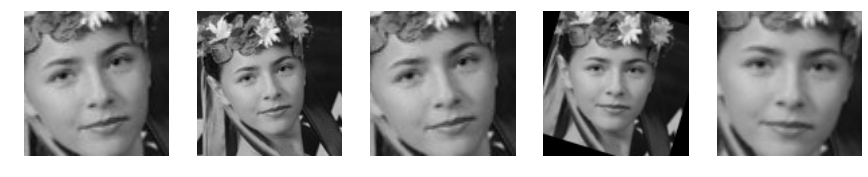

In [120]:
# Align single face
for i,(x,y,w,h) in enumerate(S_faces):
    # Extract face
    img = S_gray[y:y+h, x:x+w]

    # Align faces
    if apply_align_face:
        img = align_face(S_gray, (x,y,w,h), i, S_faces.shape[0])
    
    # resize image
    res = cv2.resize(img, (x_mean, x_mean), interpolation=cv2.INTER_CUBIC)

    # LBP
    if apply_lpb: 
        from skimage.feature import local_binary_pattern
        res = local_binary_pattern(res, n_points, radius, method="uniform")

    # Unfold matrix to vector
    res1 = res.reshape(1, res.shape[0]*res.shape[1])

    # Add image vector to the matrix
    X_test[i,:] = res1

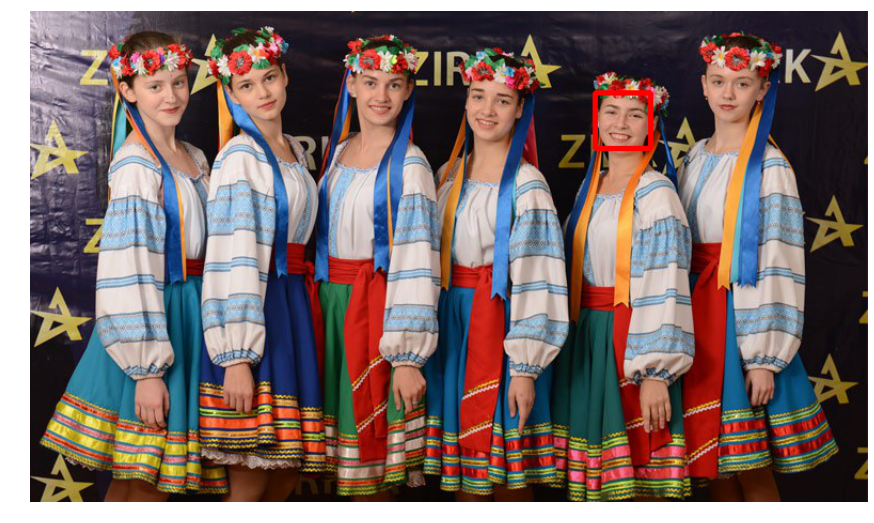

In [121]:
# Face indentification
G = cv2.imread(group_img)
S = cv2.imread(single_img)
for i, I in enumerate(X_test):
    D = X - I
    N = np.linalg.norm(D**2, axis=-1)
    idx = np.argmin(N)
    (x,y,w,h) = G_faces[idx]
    (xs,ys,ws,hs) = S_faces[i]
    cv2.rectangle(G,(x,y),(x+w,y+h),(0,0,255),4)
    cv2.rectangle(S,(xs,ys),(xs+ws,ys+hs),(0,0,255),4)

# plot image
fig = plt.figure(figsize=(15,15))
plt.axis("off")
plt.imshow(cv2.cvtColor(G, cv2.COLOR_BGR2RGB))    

In [ ]:
print X[0].shape
print I.shape
print N
print img[0,:10]

In [ ]:
import math
for i, val in enumerate(X):
    A = val
    B = X_test[0]
    nom = (A-B)**2
    den = A+B
    d = math.fsum(nom[den!=0]/den[den!=0])
    print d
#chisquare(I,X[0], axis=None)